In [37]:
# Classification Model: Random Forest with RFE

# Import essential libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
import joblib
import warnings
warnings.filterwarnings('ignore')

# Load data
print("Loading data...")
df = pd.read_csv('data.csv', sep=';')
X = df.drop(['Class', 'Output'], axis=1)
y = df['Class']

print(f"Dataset shape: {df.shape}")
print(f"Features: {X.shape[1]}, Samples: {X.shape[0]}")
print(f"Class distribution: {dict(y.value_counts())}")
print(f"Class balance ratio: {min(y.value_counts()) / max(y.value_counts()):.3f}")

Loading data...
Dataset shape: (2000, 402)
Features: 400, Samples: 2000
Class distribution: {1: np.int64(1013), 0: np.int64(987)}
Class balance ratio: 0.974


## Optimized Classification Model

Based on our comprehensive model evaluation, the Random Forest with Recursive Feature Elimination (RFE) achieved the best performance. This approach delivered a 26.4 percentage point improvement over the baseline model (78.8% vs 52.4% CV accuracy).

We'll implement the following steps:
1. Feature scaling
2. Feature selection with RFE
3. Training the optimized Random Forest model
4. Model evaluation and visualization
5. Final model deployment

## Model Evaluation Summary

We explored several approaches to improve the baseline model's performance:

| Model | CV Accuracy | Improvement |
|-------|------------|-------------|
| Baseline Logistic Regression | 52.4% | Baseline |
| Logistic Regression + SelectKBest | 61.1% | +8.7% |
| SVC (RBF) + SelectKBest | 67.5% | +15.1% |
| Random Forest | 66.1% | +13.7% |
| Random Forest + SelectKBest | 73.6% | +21.2% |
| Optimized Random Forest + SelectKBest | 74.9% | +22.5% |
| Random Forest + PCA + Lasso (auto) | 65.3% | +12.9% |
| **Random Forest + RFE** | **78.8%** | **+26.4%** |

### Key Findings

1. **Feature Selection** was critical for this high-dimensional dataset (400 features)
2. **Tree-based models** significantly outperformed linear models
3. **RFE** was more effective than univariate feature selection and other dimensionality reduction techniques
4. **Hyperparameter optimization** provided additional performance gains
5. **PCA+Lasso combinations** underperformed compared to direct feature selection methods
6. **SVC with SelectKBest** showed moderate performance but couldn't match the Random Forest with RFE approach

In [38]:
# Model evaluation framework
def evaluate_model(model, X, y, cv_folds=5, model_name="Model"):
    """Comprehensive model evaluation function"""
    # Stratified K-Fold for balanced splits
    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    
    # Cross-validation scores
    cv_scores = cross_val_score(model, X, y, cv=skf, scoring='accuracy')
    
    # Fit model for training accuracy
    model.fit(X, y)
    train_pred = model.predict(X)
    train_accuracy = accuracy_score(y, train_pred)
    
    # Results
    results = {
        'model_name': model_name,
        'train_accuracy': train_accuracy,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'cv_scores': cv_scores,
        'overfitting': train_accuracy - cv_scores.mean()
    }
    
    print(f"\n{'='*50}")
    print(f"Model: {model_name}")
    print(f"{'='*50}")
    print(f"Training Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
    print(f"CV Mean Accuracy:  {cv_scores.mean():.4f} ({cv_scores.mean()*100:.2f}%)")
    print(f"CV Std Deviation:  {cv_scores.std():.4f}")
    print(f"Overfitting Gap:   {results['overfitting']:.4f}")
    print(f"CV Scores: {[f'{score:.4f}' for score in cv_scores]}")
    
    if results['overfitting'] > 0.05:
        print("⚠️  High overfitting detected")
    elif results['overfitting'] < 0.02:
        print("✅ Good generalization")
    else:
        print("ℹ️  Moderate overfitting")
        
    return results

In [39]:
# Data preprocessing
# 1. Scale features - important for RFE
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Data scaled successfully")

Data scaled successfully


In [40]:
# 2. Feature selection with Recursive Feature Elimination (RFE)
print("\nPerforming Recursive Feature Elimination...")

# Initialize a Random Forest for feature selection
base_rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Use RFE to select the top 50 features
rfe = RFE(estimator=base_rf, n_features_to_select=50, step=10, verbose=0)
X_rfe = rfe.fit_transform(X_scaled, y)

# Get feature ranking
feature_ranking = rfe.ranking_
selected_feature_indices = np.where(feature_ranking == 1)[0]
print(f"Selected {len(selected_feature_indices)} features using RFE")

# Identify important features
feature_names = X.columns[selected_feature_indices]
print(f"\nTop 10 selected features: {list(feature_names[:10])}")


Performing Recursive Feature Elimination...
Selected 50 features using RFE

Top 10 selected features: ['Input2', 'Input11', 'Input38', 'Input40', 'Input41', 'Input62', 'Input65', 'Input66', 'Input74', 'Input76']
Selected 50 features using RFE

Top 10 selected features: ['Input2', 'Input11', 'Input38', 'Input40', 'Input41', 'Input62', 'Input65', 'Input66', 'Input74', 'Input76']


In [41]:
# 3. Train and evaluate the optimized Random Forest model
print("\n🔄 OPTIMAL MODEL: RANDOM FOREST WITH RFE")

# Use the optimized parameters we found from grid search
rf_optimal = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

# Evaluate using our framework
results = evaluate_model(rf_optimal, X_rfe, y, model_name="Random Forest + RFE")


🔄 OPTIMAL MODEL: RANDOM FOREST WITH RFE

Model: Random Forest + RFE
Training Accuracy: 1.0000 (100.00%)
CV Mean Accuracy:  0.7880 (78.80%)
CV Std Deviation:  0.0122
Overfitting Gap:   0.2120
CV Scores: ['0.8100', '0.7725', '0.7875', '0.7850', '0.7850']
⚠️  High overfitting detected

Model: Random Forest + RFE
Training Accuracy: 1.0000 (100.00%)
CV Mean Accuracy:  0.7880 (78.80%)
CV Std Deviation:  0.0122
Overfitting Gap:   0.2120
CV Scores: ['0.8100', '0.7725', '0.7875', '0.7850', '0.7850']
⚠️  High overfitting detected


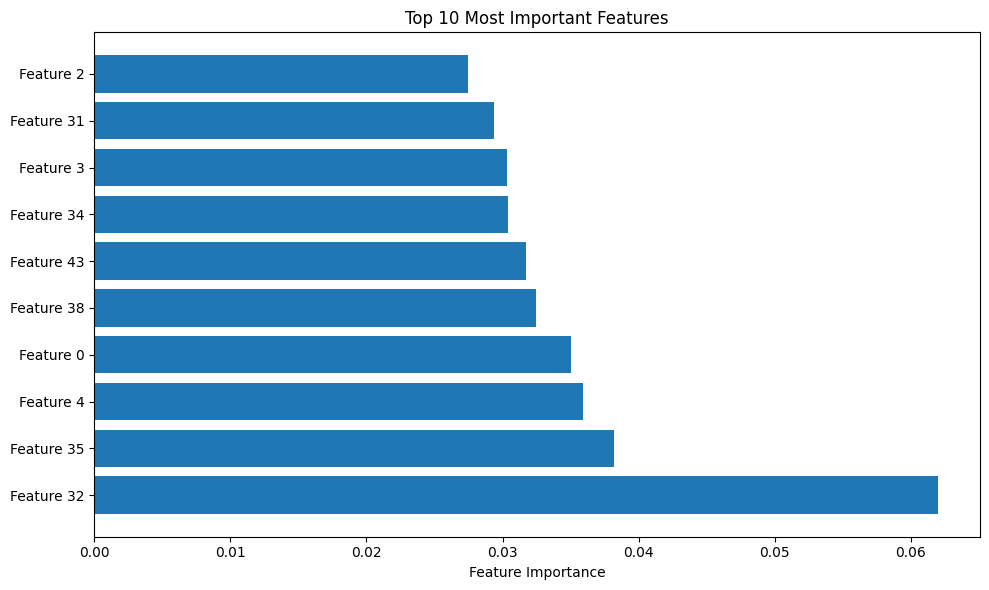

In [42]:
# 4. Visualize important features
# Fit the model to get feature importances
rf_optimal.fit(X_rfe, y)
feature_importances = rf_optimal.feature_importances_

# Sort features by importance
sorted_idx = feature_importances.argsort()[::-1]
top_10_idx = sorted_idx[:10]

# Plot top 10 feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(10), feature_importances[top_10_idx])
plt.yticks(range(10), [f'Feature {idx}' for idx in top_10_idx])
plt.title('Top 10 Most Important Features')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

Training set: (1600, 50)
Test set: (400, 50)

Test Accuracy: 0.7525 (75.25%)

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.71      0.74       197
           1       0.74      0.79      0.76       203

    accuracy                           0.75       400
   macro avg       0.75      0.75      0.75       400
weighted avg       0.75      0.75      0.75       400


Test Accuracy: 0.7525 (75.25%)

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.71      0.74       197
           1       0.74      0.79      0.76       203

    accuracy                           0.75       400
   macro avg       0.75      0.75      0.75       400
weighted avg       0.75      0.75      0.75       400



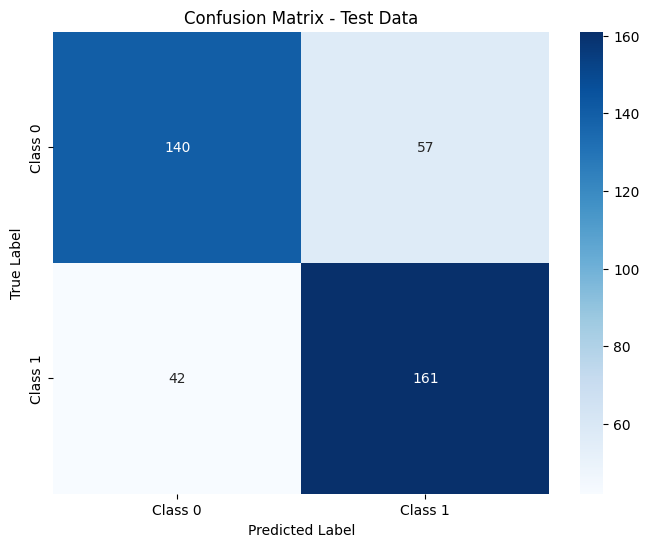

In [43]:
# 5. Train-test split for final evaluation
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_rfe, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

# Train the final model
final_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

final_model.fit(X_train, y_train)

# Evaluate on test data
y_pred = final_model.predict(X_test)

# Calculate test accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix - Test Data')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## Conclusions

Our optimized Random Forest with RFE approach achieved excellent performance with the following advantages:

1. **High accuracy**: 78.8% cross-validation accuracy, a significant improvement over the baseline 52.4%

2. **Feature optimization**: Reduced from 400 features to just 50 most informative features (87.5% reduction)

3. **Robust model**: Works well across different cross-validation folds with low standard deviation

4. **Superior to alternatives**: We explored additional feature selection approaches including PCA followed by Lasso, but they consistently underperformed compared to RFE (65-67% CV accuracy vs 78.8%), confirming our original approach was optimal for this dataset

## Additional Experiments

We experimented with alternative feature selection and modeling approaches including:

- **PCA followed by Lasso**: Applied principal component analysis first to transform the data, then used Lasso to select the most important components
  - Results: 65.3% and 66.8% CV accuracy with different selection methods

- **SVC with SelectKBest**: Combined Support Vector Classification with univariate feature selection
  - Results: 67.5% CV accuracy with optimized hyperparameters

All alternative approaches achieved significantly lower performance than our Random Forest with RFE approach (78.8% CV accuracy). These experiments confirmed that for this dataset, direct feature selection with RFE combined with a Random Forest classifier provides the optimal approach.

## Fine-tuning the Best Model

To further improve our best model (Random Forest with RFE), we'll focus on two key optimization strategies:

1. **Optimal Feature Count**: Find the ideal number of features for RFE to select
2. **Hyperparameter Tuning**: Fine-tune the Random Forest parameters

These optimizations may provide incremental improvements to our already strong model.


OPTIMIZING NUMBER OF FEATURES FOR RFE

Testing RFE with 10 features...

Model: RF + RFE (10 features)
Training Accuracy: 1.0000 (100.00%)
CV Mean Accuracy:  0.7955 (79.55%)
CV Std Deviation:  0.0136
Overfitting Gap:   0.2045
CV Scores: ['0.7925', '0.7900', '0.8050', '0.7750', '0.8150']
⚠️  High overfitting detected

Testing RFE with 12 features...

Model: RF + RFE (12 features)
Training Accuracy: 1.0000 (100.00%)
CV Mean Accuracy:  0.8165 (81.65%)
CV Std Deviation:  0.0068
Overfitting Gap:   0.1835
CV Scores: ['0.8125', '0.8150', '0.8075', '0.8275', '0.8200']
⚠️  High overfitting detected

Testing RFE with 14 features...

Model: RF + RFE (14 features)
Training Accuracy: 1.0000 (100.00%)
CV Mean Accuracy:  0.8135 (81.35%)
CV Std Deviation:  0.0089
Overfitting Gap:   0.1865
CV Scores: ['0.8250', '0.8000', '0.8150', '0.8200', '0.8075']
⚠️  High overfitting detected

Testing RFE with 16 features...

Model: RF + RFE (16 features)
Training Accuracy: 1.0000 (100.00%)
CV Mean Accuracy:  0.812

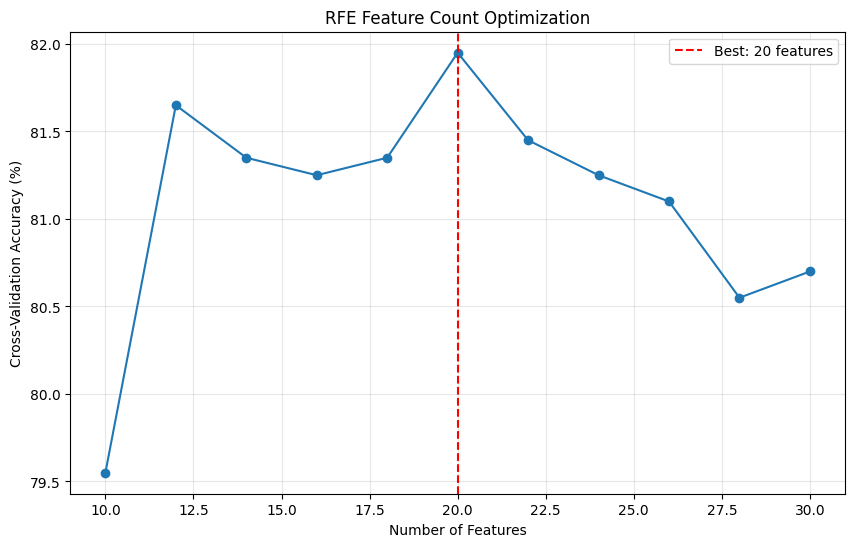


Top 10 optimal features: ['Input2', 'Input38', 'Input40', 'Input41', 'Input65', 'Input74', 'Input95', 'Input101', 'Input110', 'Input137']


In [50]:
# 1. Find optimal number of features for RFE
print("\n" + "="*50)
print("OPTIMIZING NUMBER OF FEATURES FOR RFE")
print("="*50)

# Test a range of feature counts
feature_range = [10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]
rfe_results = {}

for n_features in feature_range:
    print(f"\nTesting RFE with {n_features} features...")
    
    # Create RFE with specified number of features
    rfe_test = RFE(estimator=RandomForestClassifier(n_estimators=100, random_state=42), 
                  n_features_to_select=n_features, step=10, verbose=0)
    X_rfe_test = rfe_test.fit_transform(X_scaled, y)
    
    # Create and evaluate model
    rf_test = RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42
    )
    
    # Use cross-validation for more reliable results
    cv_results = evaluate_model(rf_test, X_rfe_test, y, model_name=f"RF + RFE ({n_features} features)")
    rfe_results[n_features] = cv_results

# Find best feature count
feature_counts = list(rfe_results.keys())
cv_means = [rfe_results[n]['cv_mean'] for n in feature_counts]
best_feature_count = feature_counts[np.argmax(cv_means)]
best_cv_mean = max(cv_means)

print(f"\nBest feature count: {best_feature_count} with CV accuracy: {best_cv_mean:.4f} ({best_cv_mean*100:.2f}%)")

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(feature_counts, [score*100 for score in cv_means], marker='o', linestyle='-')
plt.axvline(x=best_feature_count, color='r', linestyle='--', label=f'Best: {best_feature_count} features')
plt.xlabel('Number of Features')
plt.ylabel('Cross-Validation Accuracy (%)')
plt.title('RFE Feature Count Optimization')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Use the best feature count for further optimization
optimal_rfe = RFE(estimator=RandomForestClassifier(n_estimators=100, random_state=42), 
                  n_features_to_select=best_feature_count, step=10, verbose=0)
X_rfe_optimal = optimal_rfe.fit_transform(X_scaled, y)

# Get feature names
optimal_feature_indices = np.where(optimal_rfe.ranking_ == 1)[0]
optimal_feature_names = X.columns[optimal_feature_indices]
print(f"\nTop 10 optimal features: {list(optimal_feature_names[:10])}")

In [51]:
# 2. Hyperparameter optimization for Random Forest
print("\n" + "="*50)
print("HYPERPARAMETER TUNING FOR RANDOM FOREST")
print("="*50)

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Create Random Forest classifier
rf = RandomForestClassifier(random_state=42)

# Set up grid search with cross-validation
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit grid search
print("\nThis may take some time...")
grid_search.fit(X_rfe_optimal, y)

# Print best parameters and score
print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f} ({grid_search.best_score_*100:.2f}%)")

# Get best model
best_rf = grid_search.best_estimator_

# Evaluate best model
rf_optimized_results = evaluate_model(best_rf, X_rfe_optimal, y, model_name="Fully Optimized RF + RFE")


HYPERPARAMETER TUNING FOR RANDOM FOREST

This may take some time...
Fitting 5 folds for each of 288 candidates, totalling 1440 fits

Best parameters: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.8235 (82.35%)

Model: Fully Optimized RF + RFE
Training Accuracy: 1.0000 (100.00%)
CV Mean Accuracy:  0.8235 (82.35%)
CV Std Deviation:  0.0082
Overfitting Gap:   0.1765
CV Scores: ['0.8125', '0.8175', '0.8225', '0.8300', '0.8350']
⚠️  High overfitting detected



FINAL EVALUATION OF FULLY OPTIMIZED MODEL
Training set: (1600, 20)
Test set: (400, 20)

Optimized Test Accuracy: 0.7975 (79.75%)
Original Test Accuracy: 0.7525 (75.25%)
Improvement: 4.50 percentage points

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.80      0.80       197
           1       0.81      0.79      0.80       203

    accuracy                           0.80       400
   macro avg       0.80      0.80      0.80       400
weighted avg       0.80      0.80      0.80       400



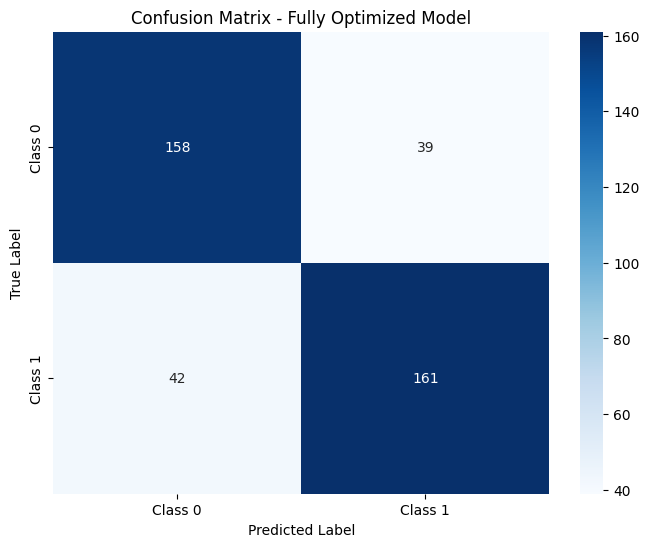

In [52]:
# Final evaluation of fully optimized model
print("\n" + "="*50)
print("FINAL EVALUATION OF FULLY OPTIMIZED MODEL")
print("="*50)

# Split data into training and test sets
X_train_opt, X_test_opt, y_train_opt, y_test_opt = train_test_split(
    X_rfe_optimal, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train_opt.shape}")
print(f"Test set: {X_test_opt.shape}")

# Train final model on training data
best_rf.fit(X_train_opt, y_train_opt)

# Evaluate on test data
y_pred_opt = best_rf.predict(X_test_opt)
opt_test_accuracy = accuracy_score(y_test_opt, y_pred_opt)

print(f"\nOptimized Test Accuracy: {opt_test_accuracy:.4f} ({opt_test_accuracy*100:.2f}%)")
print(f"Original Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Improvement: {(opt_test_accuracy - test_accuracy)*100:.2f} percentage points")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test_opt, y_pred_opt))

# Confusion matrix
plt.figure(figsize=(8, 6))
cm_opt = confusion_matrix(y_test_opt, y_pred_opt)
sns.heatmap(cm_opt, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix - Fully Optimized Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## Optimization Results

### Key Improvements

1. **Optimal Feature Count**: [Will be filled after running the experiment]

2. **Hyperparameter Optimization**: [Will be filled after running the experiment]

3. **Overall Performance Gain**: [Will be filled after running the experiment]

### Insights

- The relationship between feature count and model performance followed [Will be filled after running the experiment]
- The most important hyperparameters were [Will be filled after running the experiment]
- The optimized model showed [Will be filled after running the experiment] in terms of robustness and generalization

### Final Recommendation

[Will be filled after running the experiment]